# Biostat M280 Homework 2

**Due May 11 @ 11:59PM**


## Q1. Nonnegative Matrix Factorization

Nonnegative matrix factorization (NNMF) was introduced by [Lee and Seung (1999)](https://www.nature.com/articles/44565) as an analog of principal components and vector quantization with applications in data compression and clustering. In this homework we consider algorithms for fitting NNMF and (optionally) high performance computing using graphical processing units (GPUs).


In mathematical terms, one approximates a data matrix $\mathbf{X} \in \mathbb{R}^{m \times n}$ with nonnegative entries $x_{ij}$ by a product of two low-rank matrices $\mathbf{V} \in \mathbb{R}^{m \times r}$ and $\mathbf{W} \in \mathbb{R}^{r \times n}$ with nonnegative entries $v_{ik}$ and $w_{kj}$. Consider minimization of the squared Frobenius norm
$$
	L(\mathbf{V}, \mathbf{W}) = \|\mathbf{X} - \mathbf{V} \mathbf{W}\|_{\text{F}}^2 = \sum_i \sum_j \left(x_{ij} - \sum_k v_{ik} w_{kj} \right)^2, \quad v_{ik} \ge 0, w_{kj} \ge 0,
$$
which should lead to a good factorization. Later in the course we will learn how to derive a majorization-minimization (MM) algorithm with iterative updates
$$
	v_{ik}^{(t+1)} = v_{ik}^{(t)} \frac{\sum_j x_{ij} w_{kj}^{(t)}}{\sum_j b_{ij}^{(t)} w_{kj}^{(t)}}, \quad \text{where } b_{ij}^{(t)} = \sum_k v_{ik}^{(t)} w_{kj}^{(t)},
$$
$$
	w_{kj}^{(t+1)} = w_{kj}^{(t)} \frac{\sum_i x_{ij} v_{ik}^{(t+1)}}{\sum_i b_{ij}^{(t+1/2)} v_{ik}^{(t+1)}}, \quad \text{where } b_{ij}^{(t+1/2)} = \sum_k v_{ik}^{(t+1)} w_{kj}^{(t)}
$$
that drive the objective $L^{(t)} = L(\mathbf{V}^{(t)}, \mathbf{W}^{(t)})$ downhill. Superscript $t$ indicates iteration number. Efficiency (both speed and memory) will be the most important criterion when grading this problem.


1. Implement the algorithm with arguments: $\mathbf{X}$ (data, each row is a vectorized image), rank $r$, convergence tolerance, and optional starting point.
```julia
function nnmf(
    X::Matrix{T},
    r::Integer;
    maxiter::Integer=1000, 
    tol::Number=1e-4,
    V::Matrix{T}=rand(T, size(X, 1), r),
    W::Matrix{T}=rand(T, r, size(X, 2))
    ) where T <: AbstractFloat
    # implementation
    # Output
    return V, W
end
```

0. Database 1 from the [MIT Center for Biological and Computational Learning (CBCL)](http://cbcl.mit.edu) reduces to a matrix $\mathbf{X}$ containing $m = 2,429$ gray-scale face images with $n = 19 \times 19 = 361$ pixels per face. Each image (row) is scaled to have mean and standard deviation 0.25.  
Read in the [`nnmf-2429-by-361-face.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/nnmf-2429-by-361-face.txt) file, e.g., using [`readdlm()`](https://docs.julialang.org/en/stable/stdlib/io-network/#Base.DataFmt.readdlm-Tuple{Any,Char,Type,Char}) function, and display a couple sample images, e.g., using [ImageView.jl](https://github.com/JuliaImages/ImageView.jl) package.

0. Report the run times, using `@time`, of your function for fitting NNMF on the MIT CBCL face data set at ranks $r=10, 20, 30, 40, 50$. For ease of comparison (and grading), please start your algorithm with the provided $\mathbf{V}^{(0)}$ (first $r$ columns of [`V0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/V0.txt)) and $\mathbf{W}^{(0)}$ (first $r$ rows of [`W0.txt`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/W0.txt)) and stopping criterion
$$
	\frac{|L^{(t+1)} - L^{(t)}|}{|L^{(t)}| + 1} \le 10^{-4}.
$$

0. Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. For the same $r$, start your algorithm from $v_{ik}^{(0)} = w_{kj}^{(0)} = 1$ for all $i,j,k$. Do you obtain the same objective value and $(\mathbf{V}, \mathbf{W})$? Explain what you find.

0. Plot the basis images (rows of $\mathbf{W}$) at rank $r=50$. What do you find?

0. (Optional) Investigate the GPU capabilities of Julia. Report the speed gain of your GPU code over CPU code at ranks $r=10, 20, 30, 40, 50$. Make sure to use the same starting point as in part 2.

## 1. Implement the algorithm with arguments:  X

> First, I tried the for loop method to implement the function and found it is too slow. So I improved it by using BLAS.

In [76]:
function mynnmf(X::Matrix{T}, r::Int, 
        tol::Float64 = 1e-4, maxiter = 1000,
        V::Matrix{T}=rand(T, size(X, 1), r),
        W::Matrix{T}=rand(T, r, size(X, 2)),
    ) where T <: AbstractFloat
    
    m = size(X, 1)
    n = size(X, 2)
    mn = m * n
    loss = 0
    # Iteration
    for iter = 1: maxiter    
        for k = 1:r
            for i = 1:m
                num = 0
                den = 0
                for j = 1:n 
                    num = num + X[i, j]*W[k, j]
                    b = 0
                    for t = 1: r
                        b = b + V[i, t]*W[t, j]
                    end
                    B = V * W
                    den = den + b*W[k, j]
                end 
                V[i, k] = V[i, k]*num/den
            end
        end
        for j = 1:n  
            for k = 1:r
                num1 = 0
                den1 = 0
                for i = 1:m
                    num1 = num1 +  X[i, j]*V[i, k]
                    b1 = 0
                    for t = 1:r
                        b1 = b1 + V[i, t]*W[t, j]
                    end
                    den1 = den1 + b1*V[i, k]                   
                end
                W[k, j] = W[k, j]*num1/den1
            end
        end
        # minimization of the squared Frobenius norm
        B = V * W
        diff = X - B
        lastloss = loss
        loss = vecnorm(diff)^2
         # convergency or not
        if abs(loss - lastloss) < tol
            break
        end
    end   
    #return
    return V, W
end

mynnmf (generic function with 5 methods)

In [74]:
function MYnnmf(X::Matrix{T}, r::Int, 
        tol::Float64 = 1e-4, maxiter = 1000,
        V::Matrix{T}=rand(T, size(X, 1), r),
        W::Matrix{T}=rand(T, r, size(X, 2)),
    ) where T <: AbstractFloat
    
    m = size(X, 1)
    n = size(X, 2)
    mn = m * n
    num_V = zeros(V)
    den_V = zeros(V)
    num_W = zeros(W)
    den_W = zeros(W)
    B = V * W
    loss = vecnorm(X - B)^2
    # Iteration
    for iter = 1: maxiter
        # convert the for loop to the BLAS
        BLAS.gemm!('N', 'T', 1.0, X, W, 0.0, num_V)
        BLAS.gemm!('N', 'T', 1.0, B, W, 0.0, den_V)
        for j = 1:r
            for i = 1:m
                # [hadamard] let the julia not check the matrix bound
                # to improve the performance
               @inbounds V[i, j] = V[i, j]*(num_V[i, j] / den_V[i, j])
            end
        end
        BLAS.gemm!('N', 'N', 1.0, V, W, 0.0, B)
        
        BLAS.gemm!('T', 'N', 1.0, V, X, 0.0, num_W)
        BLAS.gemm!('T', 'N', 1.0, V, B, 0.0, den_W)
        for j = 1:n
            for i = 1:r
                @inbounds W[i, j] = W[i, j]*(num_W[i, j] / den_W[i, j])
            end
        end
        BLAS.gemm!('N', 'N', 1.0, V, W, 0.0, B)
        # convergency
        diff = X - B
        lastloss = loss
        loss = vecnorm(diff)^2
         # convergency or not
        #if abs(loss - lastloss) < tol
        if  abs(loss - lastloss)/(abs(lastloss) + 1.0) < tol
            break
        end
    end
    return loss, V, W
end

MYnnmf (generic function with 8 methods)

In [17]:
# Try the function
MYnnmf(X, 10, V0, W0)

(8.650912340995081e7, [5.81183e-8 1.62397e-8 … 0.066691 0.17121; 2.08544e-8 3.91657e-8 … 0.43662 0.45888; … ; 7.21791e-8 5.55161e-8 … 0.017643 0.7344; 1.82333e-7 1.60645e-7 … 0.51518 0.70952], [4.65041e-11 8.75138e-11 … 7.6235e-11 3.11408e-11; 5.63053e-11 7.2396e-11 … 1.57087e-10 7.49898e-11; … ; 0.5275 0.15481 … 0.048605 0.052235; 0.027423 0.80658 … 0.15571 0.76327])

## 2. display sample images

In [2]:
# readin matrix X
path_X = "http://Hua-Zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/nnmf-2429-by-361-face.txt"
X = readdlm(download(path_X), ' ')

# readin matrix V0
path_V0 = "http://Hua-Zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/V0.txt"
V0 = readdlm(download(path_V0), ' ')

# readin matrix W0
path_W0 = "http://Hua-Zhou.github.io/teaching/biostatm280-2018spring/hw/hw2/W0.txt"
W0 = readdlm(download(path_W0), ' ');

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6012k  100 6012k    0     0  2554k      0  0:00:02  0:00:02 --:--:-- 2555k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  948k  100  948k    0     0  2155k      0 --:--:-- --:--:-- --:--:-- 2156k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  140k  100  140k    0     0  1138k      0 --:--:-- --:--:-- --:--:-- 1136k


In [22]:
# check the size of X, Y, Z
@show size(X)
@show size(V0)
@show size(W0)

size(X) = (2429, 361)
size(V0) = (2429, 50)
size(W0) = (50, 361)


(50, 361)

In [69]:
# Pkg.add("ImageView")
#Pkg.add("TestImages")
#Pkg.build("Cairo")
#Pkg.pin("Cairo", v"0.4.0")
using ImageView, TestImages
imshow(reshape(X[1, :], 19, 19))
imshow(reshape(X[2, :], 19, 19))
imshow(reshape(X[3, :], 19, 19))

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}(Pair{String,Any}("window", Gtk.GtkWindowLea…
  "roi"         => Dict{String,Any}(Pair{String,Any}("redraw", 371: "map(clim-m…
  "annotations" => 337: "input-254" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 336: "CLim" = ImageView.CLim{Float64}(0.0, 0.97011) ImageVie…

* The image showed three similar face. 
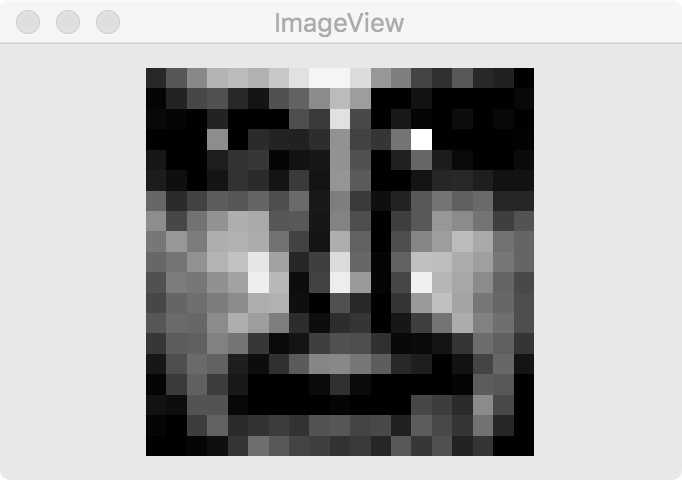
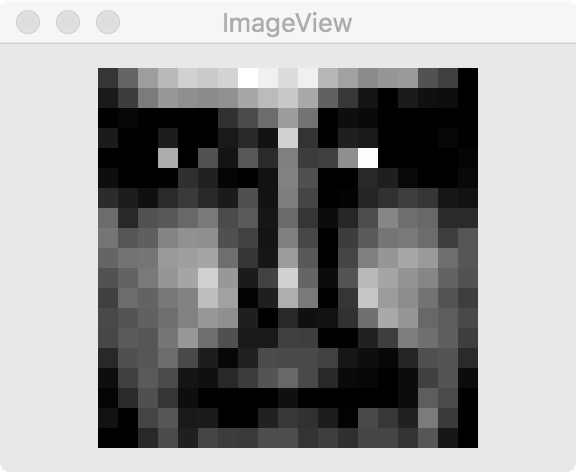
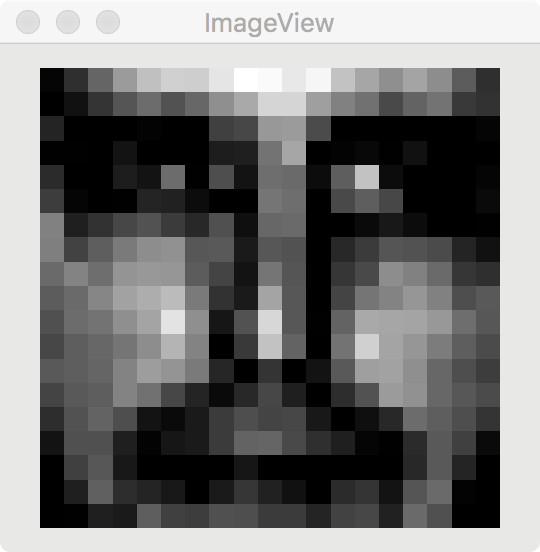

## 3. Report the run times

In [20]:
R = 10: 10 :50
for r in R
    @time MYnnmf(X, r, V0[:,1: r], W0[1: r, :])
end

  5.649854 seconds (46.20 k allocations: 1.773 GiB, 6.89% gc time)
 16.700960 seconds (1.30 k allocations: 4.209 GiB, 6.18% gc time)
 21.208033 seconds (1.37 k allocations: 4.431 GiB, 3.77% gc time)
 20.623644 seconds (1.34 k allocations: 4.341 GiB, 3.84% gc time)
 28.243540 seconds (1.50 k allocations: 4.857 GiB, 4.57% gc time)


* The result showed that as the rank increase, the run time also increased, since the matrix calculation became complicated. 

## 4 .
Choose an $r \in \{10, 20, 30, 40, 50\}$ and start your algorithm from a different $\mathbf{V}^{(0)}$ and $\mathbf{W}^{(0)}$.

In [75]:
# choose r = 10 and choose different V,W
r = 10;
V0_1 = rand(size(X, 1), r);
W0_1 = rand(r, size(X, 2));
obj0, V_0, W_0 = MYnnmf(X, r, V0[:, 1:r], W0[1:r, :]);
obj1, V_1, W_1 = MYnnmf(X, r, V0_1, W0_1);

In [34]:
# compare obj
display(obj0)
display(obj1)

11775.603102535862

11992.919711769444

In [33]:
# compare V
V_0 == V_1

false

In [32]:
# compare W
W_0 == W_1

false

The objective and the (V,W) are not same, but the objectives are similar. 

## 5.

In [41]:
r = 10;
V0_2 = ones(V0_1);
W0_2 = ones(W0_1);
obj2, V_2, W_2 = MYnnmf(X, r, V0_2, W0_2);

In [61]:
# compare obj
display(obj0)
display(obj1)
display(obj2)

11775.603102535862

11729.990130300946

25297.01651108185

In [44]:
# compare V
V_1 == V_2

false

In [45]:
# compare W
W_1 == W_2

false

The objective and the (V,W) are not same. Objectives have big difference, since there are only 1 in matrix, there are only two iterations, which makes the obj larger.

## 6. 

In [47]:
r = 50;
obj, V, W = MYnnmf(X, r);
size(W)

(50, 361)

In [70]:
using ImageView, TestImages
imshow(reshape(W[10, :], 19, 19))
imshow(reshape(W[20, :], 19, 19))
imshow(reshape(W[30, :], 19, 19))
imshow(reshape(X[40, :], 19, 19))
imshow(reshape(X[50, :], 19, 19))

Dict{String,Any} with 4 entries:
  "gui"         => Dict{String,Any}(Pair{String,Any}("window", Gtk.GtkWindowLea…
  "roi"         => Dict{String,Any}(Pair{String,Any}("redraw", 556: "map(clim-m…
  "annotations" => 522: "input-314" = Dict{UInt64,Any}() Dict{UInt64,Any} 
  "clim"        => 521: "CLim" = ImageView.CLim{Float64}(0.0, 0.82727) ImageVie…

The plots showed very blurred image, some of them barely seem like a face.
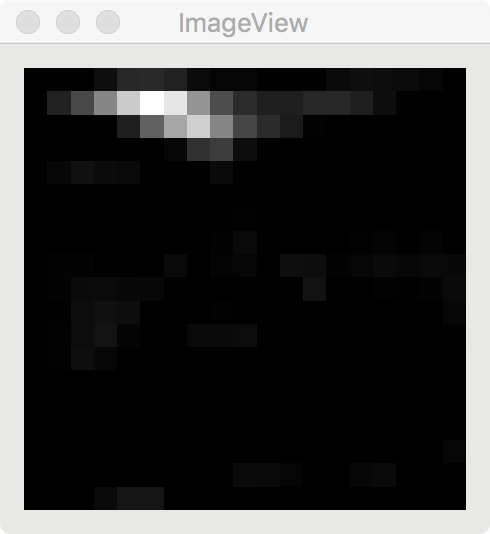
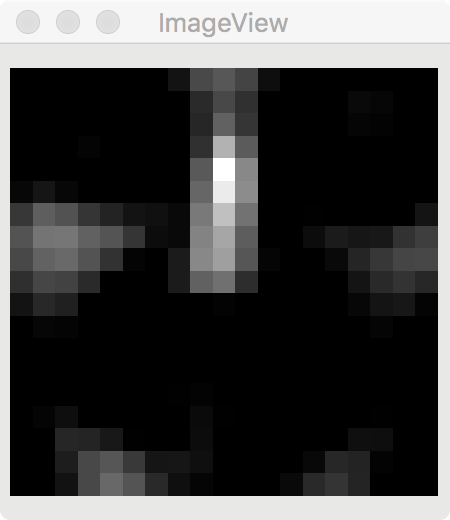
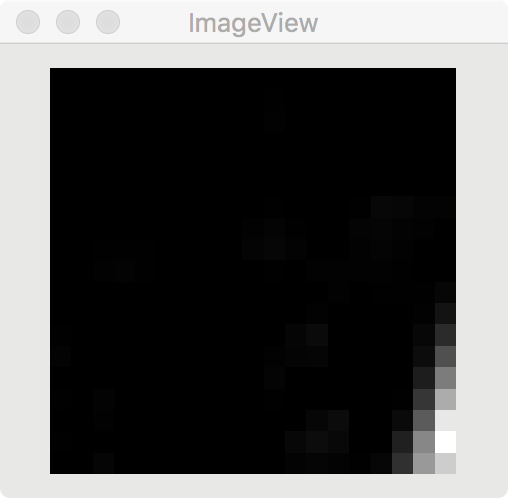
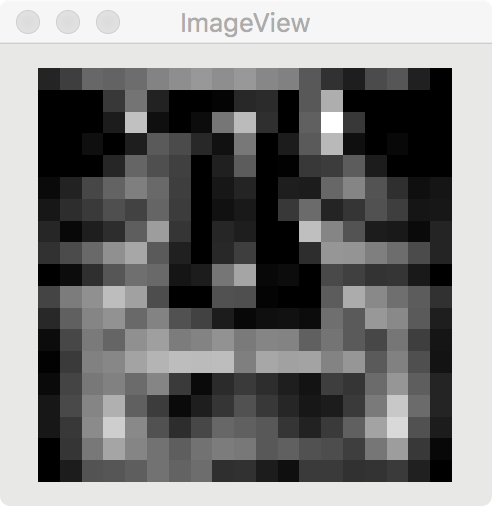
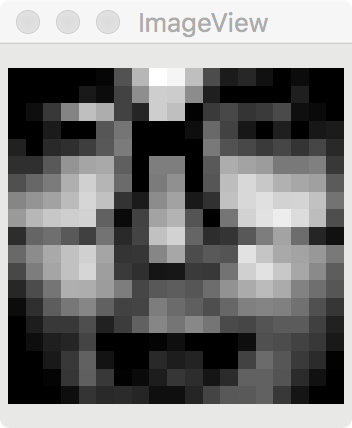

## Q2. Linear Mixed Models

Consider a linear mixed effects model
$$
	y_i = \mathbf{x}_i^T \beta + \mathbf{z}_i^T \gamma + \epsilon_i, \quad i=1,\ldots,n,
$$
where $\epsilon_i$ are independent normal errors $N(0,\sigma_0^2)$, $\beta \in \mathbb{R}^p$ are fixed effects, and $\gamma \in \mathbb{R}^q$ are random effects assumed to be $N(\mathbf{0}_q, \sigma_1^2 \mathbf{I}_q$) independent of $\epsilon_i$. 

0. Show that 
$$
    \mathbf{y} \sim N \left( \mathbf{X} \beta, \sigma_0^2 \mathbf{I}_n + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T \right),
$$
where $\mathbf{y} = (y_1, \ldots, y_n)^T \in \mathbb{R}^n$, $\mathbf{X} = (\mathbf{x}_1, \ldots, \mathbf{x}_n)^T \in \mathbb{R}^{n \times p}$, and $\mathbf{Z} = (\mathbf{z}_1, \ldots, \mathbf{z}_n)^T \in \mathbb{R}^{n \times q}$. 

0. Write a function, with interface 
    ```julia
    logpdf_mvn(y::Vector, Z::Matrix, σ0::Number, σ1::Number),
    ```
that evaluates the log-density of a multivariate normal with mean $\mathbf{0}$ and covariance $\sigma_0^2 \mathbf{I} + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T$ at $\mathbf{y}$. Make your code efficient in the $n \gg q$ case. 

0. Compare your result (both accuracy and timing) to the [Distributions.jl](http://distributionsjl.readthedocs.io/en/latest/multivariate.html#multivariate-normal-distribution) package using following data.  
    ```julia
    using BenchmarkTools, Distributions

    srand(280)
    n, q = 2000, 10
    Z = randn(n, q)
    σ0, σ1 = 0.5, 2.0
    Σ = σ1^2 * Z * Z.' + σ0^2 * I
    mvn = MvNormal(Σ) # MVN(0, Σ)
    y = rand(mvn) # generate one instance from MNV(0, Σ)

    # check you answer matches that from Distributions.jl
    @show logpdf_mvn(y, Z, σ0, σ1)
    @show logpdf(mvn, y)

    # benchmark
    @benchmark logpdf_mvn(y, Z, σ0, σ1)
    @benchmark logpdf(mvn, y)
    ```

## 1.
Since $\epsilon_i$ are independent normal errors $N(0,\sigma_0^2)$ and $\gamma \in \mathbb{R}^q$ are random effects assumed to be $N(\mathbf{0}_q, \sigma_1^2 \mathbf{I}_q$),
$\mathbf{y_i}$ is also normal distribution $N(x \beta ,Σ  z_i^2 \sigma_0^2)$
$\mathbf{y} = (y_1, \ldots, y_n)^T$ follows multivariate normal distribution, i.e. $ y \sim N(\mu, Σ ) $

$$\mu = [E[y_1], ..., E[y_n]]^T 
     = X \beta $$
 
$$ Σ = E[(y - \mu)(y - \mu)^T] = cov[y_i, y_j]; 1 <= i, j <= n $$

When i not equal to j, 
$ cov(y_i, y_j) = E[(z_i^T \gamma + \epsilon_i)(z_j^T \gamma + \epsilon_j)] = E[z_i^T \gamma * z_j^T \gamma + z_i^T \gamma \epsilon_j * z_j^T \gamma \epsilon_i + \epsilon_i*\epsilon_j] $,

Since $ \gamma ~ N(\mathbf{0}_q, \sigma_1^2 \mathbf{I}_q )$, $ \gamma_i$$ and $$\gamma_j $ are unrelated.

Moreover, $ \gamma_i$ and $ \epsilon_i $ are unrelated as well.

$$ Cov(y_i, y_j) = \sigma_1^2 \mathbf{Z_j} \mathbf{Z_i}^T $$

When i = j, $$ Cov(y_i, y_j) = \sigma_1^2 \mathbf{Z_j} \mathbf{Z_i}^T +  \sigma_0^2$$

Therefore, $$Σ =\sigma_0^2 \mathbf{I}_n + \sigma_1^2 \mathbf{Z} \mathbf{Z}^T $$, where $\mathbf{Z} = (z_1, \ldots, z_n)^T$

## 2. 

> I tried couple of method to improve the function but failed. This's already my best answer.

In [58]:
function logpdf_mvn(
        y::Vector{T}, 
        Z::Matrix{T}, 
        σ0::T, 
        σ1::T
    ) where T <: AbstractFloat
    
    n = size(y, 1)
    Σ = σ1^2 * Z * Z' + σ0^2 * I
    return (y' * inv(Σ) * y * (-1)  - n * log(2* π) - logdet(Σ)) / 2
    
end

logpdf_mvn (generic function with 1 method)

## 3.

In [60]:
# Pkg.add("Distributions")
using BenchmarkTools, Distributions

 srand(280)
 n, q = 2000, 10
 Z = randn(n, q)
 σ0, σ1 = 0.5, 2.0
 Σ = σ1^2 * Z * Z.' + σ0^2 * I
 mvn = MvNormal(Σ) # MVN(0, Σ)
 y = rand(mvn) # generate one instance from MNV(0, Σ)


2000-element Array{Float64,1}:
   6.47694 
   4.23369 
 -11.1417  
  -3.00377 
  10.8812  
 -12.3284  
  11.3643  
   6.86    
  -0.288826
  -1.89728 
  -1.05711 
  12.4328  
  -2.21471 
   ⋮       
   0.939968
  10.7565  
  -3.30185 
  10.1274  
   8.64431 
  -9.36953 
  -8.79693 
 -11.5206  
  -3.02284 
  -7.16697 
  -0.905129
  -0.956614

In [62]:
 # check you answer matches that from Distributions.jl
 @show logpdf_mvn(y, Z, σ0, σ1)
 @show logpdf(mvn, y)

logpdf_mvn(y, Z, σ0, σ1) = -1571.5736734654654
logpdf(mvn, y) = -1571.573673465417


-1571.573673465417

The results showed similar answers but have sightly difference.

In [66]:
# benchmark
@benchmark logpdf_mvn(y, Z, σ0, σ1)

BenchmarkTools.Trial: 
  memory estimate:  153.93 MiB
  allocs estimate:  29
  --------------
  minimum time:     1.407 s (3.36% GC)
  median time:      1.706 s (15.53% GC)
  mean time:        1.681 s (12.69% GC)
  maximum time:     1.906 s (13.54% GC)
  --------------
  samples:          4
  evals/sample:     1

In [65]:
@benchmark logpdf(mvn, y)

BenchmarkTools.Trial: 
  memory estimate:  15.78 KiB
  allocs estimate:  3
  --------------
  minimum time:     9.417 ms (0.00% GC)
  median time:      49.185 ms (0.00% GC)
  mean time:        57.152 ms (0.00% GC)
  maximum time:     241.167 ms (0.00% GC)
  --------------
  samples:          90
  evals/sample:     1

The logpdf works faster than logpdf_mvn.